# Using different attributes to determine the presence of heart disease in patients of Hungary

# Introduction
Heart disease, or cardiovascular disease, refers to conditions affecting the heart, often involving narrowed or blocked blood vessels that can lead to a heart attack. Both men and women face increased risk with age. High cholesterol can lead to fatty deposits in blood vessels, increasing the risk of blockages and heart attacks. Men tend to have a higher risk at a younger age compared to women. We aim to classify patients' likelihood of heart disease using age, sex, and cholesterol.

Question: How does the combination of **age**, **sex**, and **cholesterol levels** influence the likelihood of developing **heart disease** in individuals?

The dataset we will be using will be the Hungary Heart Disease database (“reprocessed. Hungarian.data”); a data set intended to determine the presence of heart disease in patients of Hungary. It contains data on 14 variables, including age, sex, etc. 

# Methods

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
set.seed(17)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [67]:
#copying the code from the proposal over

url <- "https://raw.githubusercontent.com/ANGUO17/dsci-100-2023w2-group-06/main/heart%2Bdisease/reprocessed.hungarian.data"

data <- read.table(url) 

data <- data.frame(lapply(data, function(x) gsub("-9", "NA", x)))
           
colnames(data) <- c("age", "sex", "cp", "trestbps", "chol" , "fbs", 
                    "restecg", "thalach", "exang", "oldpeak", "slope", "ca",
                    "thal", "num")

data_processed <- data |>
    mutate(age = as.numeric(age)) |>
    mutate(trestbps = as.numeric(trestbps)) |>
    mutate(chol = as.numeric(chol)) |>
    mutate(thalach = as.numeric(thalach)) |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>
    mutate(cp = as_factor(cp)) |>
    mutate(cp = fct_recode(cp, "typical angina" = "1", "atypical angina" = "2", 
                                        "non-anginal pain" = "3" , "asymptomatic" = "4" )) |>
    mutate(fbs = as_factor(fbs)) |>
    mutate(fbs = fct_recode(fbs, "true" = "1", "false" = "0" )) |>
    mutate(restecg = as_factor(restecg)) |>
    mutate(restecg = fct_recode(restecg, "normal" = "0", "abnormal" = "1" )) |>
    mutate(exang = as_factor(exang)) |>
    mutate(exang = fct_recode(exang, "yes" = "1", "no" = "0" )) |>
    mutate(slope = as_factor(slope)) |>
    mutate(slope = fct_recode(slope, "upsloping" = "1", "flat" = "2", "downsloping" = "3")) |>
    mutate(thal = as_factor(thal)) |>
    mutate(thal = fct_recode(thal, "normal" = "3", "fixed defect" = "6", "reversable defect" = "7" )) |>
    mutate(diagnosis = as_factor(num)) |>
    mutate(diagnosis = fct_recode(diagnosis, "Sick" = "1","Sick" = "2" ,"Sick" = "3","Sick" = "4", "Healthy" = "0" )) |>

    select(age, sex, chol, diagnosis)

data_split <- initial_split(data_processed, prop = 0.75, strata = diagnosis)  

data_training <- training(data_split)

data_testing <- testing(data_split)

data_summarized <- data_training |>
    group_by(diagnosis, sex) |>
    summarize(mean_age = mean(age, na.rm = TRUE),
              mean_chol = mean(chol, na.rm = TRUE),
              count = n())

data_summarized

training_plot <- data_training|> ggplot(aes(x = age, y = chol, color = diagnosis)) + 
    geom_point() + facet_grid(cols = vars(sex)) + labs(x = "Age (years)", y = "Serum Cholesterol in mg/dl", color = "Diagnosis")


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `trestbps = as.numeric(trestbps)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `chol = as.numeric(chol)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `thalach = as.numeric(thalach)`.
Caused by warning:
! NAs introduced by coercion”
`summarise()` has grouped output by 'diagnosis'. You can override using the
`.groups` argument.


diagnosis,sex,mean_age,mean_chol,count
<fct>,<fct>,<dbl>,<dbl>,<int>
Healthy,male,46.63441,237.9762,93
Healthy,female,47.87500,239.9524,48
Sick,male,49.25000,269.5385,68
Sick,female,49.45455,287.8182,11


In [85]:
#recipe
set.seed(17)
data_training2 <- data_training |>
   drop_na() |>
   mutate(sex = as.numeric(sex))
head(data_training2)

hungary_recipe <- recipe(diagnosis ~ age + sex + chol  , data = data_training2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
hungary_recipe
#male = 1, female = 2

,age,sex,chol,diagnosis
,<dbl>,<dbl>,<dbl>,<fct>
1,37,1,283,Healthy
2,39,1,339,Healthy
3,54,1,208,Healthy
4,48,2,284,Healthy
5,37,2,211,Healthy
6,39,1,204,Healthy




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



neighbors,mean
<dbl>,<dbl>
3,0.6485714
4,0.6485714
13,0.6440476
⋮,⋮
46,0.590
41,0.575
42,0.575


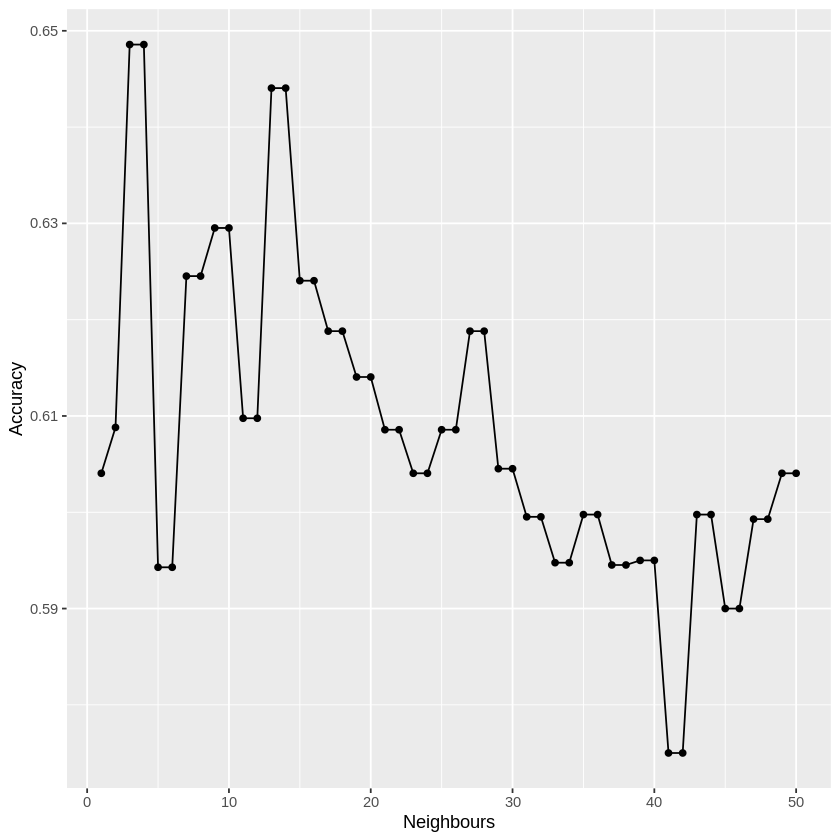

In [87]:
#
set.seed(17)
hungary_vfold <-  vfold_cv(data_training2, v = 5, strata = diagnosis)
hungary_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")


values <- tibble(neighbors = seq(from = 1 , to = 50, by = 1 ))

best_fit <- workflow() |>
    add_recipe(hungary_recipe) |>
    add_model(hungary_spec) |>
    tune_grid(resamples = hungary_vfold , grid = values) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))
best_fit

best_k_plot <- best_fit |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy")

best_k_plot

#use 3 neighbors

In [93]:
set.seed(17)
hungary_spec2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

hungary_fit <- workflow() |>
    add_recipe(hungary_recipe) |>
    add_model(hungary_spec2) |>
    fit(data = data_training2)

data_testing2 <- data_testing |>
    drop_na() |>
    mutate(sex = as.numeric(sex)) 
data_testing2

hungary_predictions <- predict(hungary_fit, data_testing2) |>
    bind_cols(data_testing2)

hungary_metrics <- hungary_predictions |>
     metrics(truth = diagnosis, estimate = .pred_class) |>
     filter(.metric == "accuracy")
 hungary_metrics 

 hungary_conf_mat <- hungary_predictions |>
     conf_mat(truth = diagnosis , estimate = .pred_class)
    
 hungary_conf_mat

age,sex,chol,diagnosis
<dbl>,<dbl>,<dbl>,<fct>
40,1,289,Healthy
48,2,214,Sick
45,2,237,Healthy
⋮,⋮,⋮,⋮
51,2,220,Healthy
48,1,211,Healthy
53,1,182,Healthy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6086957


          Truth
Prediction Healthy Sick
   Healthy      33   16
   Sick         11    9

Each report should include the following sections:

Title

Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and describe the dataset that was used to answer the question

Methods & Results:
describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
loads data from the original source on the web 
wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend

Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.
hint - you can use your proposal as a basis for your final report